# Pre - EDA Work
e.g. data reading, imports

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from snowflake.ml.modeling.preprocessing import *
from snowflake.ml.modeling.impute import *

import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

## Save snowflake details

In [2]:
warehouse = "amazon_sagemake_w_snowflake_as_datasource"
database = "adtracking"
schema = "adtracking_schema"
table_training = "adtracking_clicks_train"
table_testing = "adtracking_clicks_test"

In [3]:
accountname = os.getenv("sf_account_id")
username = os.getenv("sf_username")
password = os.getenv("sf_password")

In [4]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN"
}

In [5]:
connection_parameters["database"] = database
connection_parameters["schema"] = schema
connection_parameters["warehouse"] = warehouse
with open('creds.json', 'w') as outfile:
        outfile.write(json.dumps(connection_parameters))

## Create Snowpark session

In [6]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [7]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "ADTRACKING"."ADTRACKING_SCHEMA"
Current Warehouse: "AMAZON_SAGEMAKE_W_SNOWFLAKE_AS_DATASOURCE"


## Create Snowpark DataFrames

In [8]:
snowpark_df_train = session.table("ADTRACKING_CLICKS_TRAIN")
snowpark_df_test = session.table("ADTRACKING_CLICKS_TEST")

# Begin EDA

## Overview of train / test tables
Note that we know from the dataset description that there should be no missing data.  Normally would have work near the start getting rid of duplicates, imputing/deleting missing values, etc.

In [9]:
print(f"There are {snowpark_df_train.count()} rows in the training data \n"
      f"There are {snowpark_df_test.count()} rows in the testing data")

There are 184903890 rows in the training data 
There are 18790469 rows in the testing data


In [10]:
print(f"There are {len(snowpark_df_train.columns)} columns in the training data. These are {snowpark_df_train.columns} \n"
      f"There are {len(snowpark_df_test.columns)} colums in the testing data. These are {snowpark_df_test.columns}")

There are 8 columns in the training data. These are ['IP', 'APP', 'DEVICE', 'OS', 'CHANNEL', 'CLICK_TIME', 'ATTRIBUTED_TIME', 'IS_ATTRIBUTED'] 
There are 7 colums in the testing data. These are ['CLICK_ID', 'IP', 'APP', 'DEVICE', 'OS', 'CHANNEL', 'CLICK_TIME']


In [11]:
snowpark_df_train.describe().show()

-------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"IP"               |"APP"               |"DEVICE"            |"OS"                |"CHANNEL"           |"IS_ATTRIBUTED"      |
-------------------------------------------------------------------------------------------------------------------------------------------
|min        |1.0                |0.0                 |0.0                 |0.0                 |0.0                 |0.0                  |
|stddev     |69527.89473043308  |14.805210400396206  |259.33264471909433  |55.252817385179554  |129.58815206260178  |0.04964876634922564  |
|count      |184903890.0        |184903890.0         |184903890.0         |184903890.0         |184903890.0         |184903890.0          |
|max        |364778.0           |768.0               |4227.0              |956.0               |500.0               |1.0                  |
|mean       |90876.0

In [12]:
snowpark_df_test.describe().show()

----------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"CLICK_ID"         |"IP"               |"APP"               |"DEVICE"           |"OS"                |"CHANNEL"           |
----------------------------------------------------------------------------------------------------------------------------------------
|min        |0.0                |0.0                |0.0                 |0.0                |0.0                 |0.0                 |
|mean       |9395234.0          |63069.206654       |12.214796           |1.730513           |18.733115           |264.805942          |
|stddev     |5424341.312012224  |36885.96625585281  |11.649235854767472  |25.97037666265162  |11.350593420610219  |135.52543355769058  |
|count      |18790469.0         |18790469.0         |18790469.0          |18790469.0         |18790469.0          |18790469.0          |
|max        |18790468.0         |126413.0

In [13]:
# Counts of app downnloaded vs not downloaded in training data
snowpark_df_train.group_by("is_attributed").agg(F.count("*").as_("count")).show()

-------------------------------
|"IS_ATTRIBUTED"  |"COUNT"    |
-------------------------------
|1                |456846     |
|0                |184447044  |
-------------------------------



We can see that we have a huge mismatch in the app being downloaded vs not, as we would expect.  This will necessitate some work later to deal with our imbalanced classes assuming our testing data is representative of our training data.  About 0.25% of our test rows resulted in a download

In [14]:
# Ensure that we have no rows where there was a download, but no download time stored
snowpark_df_train.filter(F.col("is_attributed") == 1 & F.col("attributed_time").isNull()).show()

---------------------------------------------------------------------------------------------------
|"IP"  |"APP"  |"DEVICE"  |"OS"  |"CHANNEL"  |"CLICK_TIME"  |"ATTRIBUTED_TIME"  |"IS_ATTRIBUTED"  |
---------------------------------------------------------------------------------------------------
|      |       |          |      |           |              |                   |                 |
---------------------------------------------------------------------------------------------------



We see no issues with our above check.  If any had existed, we would have removed them.

In [15]:
encoded_vars = ['IP', 'APP', 'DEVICE', 'OS', 'CHANNEL'] # IS_ATTRIBUTED is not in test, only 2 categories
unique_vals_train = []
unique_vals_test = []
for col in encoded_vars:
    unique_vals_train.append([col, snowpark_df_train.select(col).distinct().count()])
    unique_vals_test.append([col, snowpark_df_test.select(col).distinct().count()])


train_cat_counts = pd.DataFrame(unique_vals_train, columns=['COL_NAME', 'NUM_CATEGORIES'])
test_cat_counts = pd.DataFrame(unique_vals_test, columns=['COL_NAME', 'NUM_CATEGORIES'])

In [16]:
train_cat_counts.head()

,COL_NAME,NUM_CATEGORIES
0,IP,277396
1,APP,706
2,DEVICE,3475
3,OS,800
4,CHANNEL,202


In [17]:
test_cat_counts.head()

,COL_NAME,NUM_CATEGORIES
0,IP,93936
1,APP,417
2,DEVICE,1985
3,OS,395
4,CHANNEL,178


In [18]:
# Check time periods for training vs. testing data
min_time_train = snowpark_df_train.select(F.min("CLICK_TIME").as_("Training Min Click Time")).collect()
max_time_train = snowpark_df_train.select(F.max("CLICK_TIME").as_("Training Max Click Time")).collect()

min_time_test = snowpark_df_test.select(F.min("CLICK_TIME").as_("Testing Min Click Time")).collect()
max_time_test = snowpark_df_test.select(F.max("CLICK_TIME").as_("Testing Max Click Time")).collect()

In [19]:
print(f"{min_time_test}, {max_time_test}\n"
      f"{min_time_train}, {max_time_train})")

[Row(Testing Min Click Time=datetime.datetime(2017, 11, 10, 4, 0))], [Row(Testing Max Click Time=datetime.datetime(2017, 11, 10, 15, 0))]
[Row(Training Min Click Time=datetime.datetime(2017, 11, 6, 14, 32, 21))], [Row(Training Max Click Time=datetime.datetime(2017, 11, 9, 16, 0))])


From the above we can see that our training data runs from Nov. 6th, 2017 to Nov. 9th, 2017.
Our testing data is just on Nov. 11th, 2017.
No overlap, slight delay between them.

### OS seems like it could be a good predictor of if a click is attributed or not from the below two lines

In [20]:
snowpark_df_train.group_by(F.col("OS")).agg(F.count("IS_ATTRIBUTED").alias("QTY_ATTR")).sort("QTY_ATTR", ascending=False).show(5)

---------------------
|"OS"  |"QTY_ATTR"  |
---------------------
|19    |44181914    |
|13    |39782808    |
|17    |9639776     |
|18    |8974159     |
|22    |7414405     |
---------------------



In [21]:
snowpark_df_train.group_by(F.col("OS")).agg(F.count("IS_ATTRIBUTED").alias("QTY_ATTR")).sort("QTY_ATTR", ascending=True).show(5)

---------------------
|"OS"  |"QTY_ATTR"  |
---------------------
|650   |1           |
|330   |1           |
|563   |1           |
|872   |1           |
|702   |1           |
---------------------



Lets now do a deeper dive on our training data.  We will convert the snowpark_df_train to pandas and perform further EDA.  Training data is only up to ~5100 MB as a pandas dataframe and as such we can use it directly.

## Further EDA with the training data
Use the pandas dataframe of the training data. Only ~5100 MB so we can still manipulate it directly here.  Useful for graphing and deciding on feature importance visually

In [22]:
pandas_train = snowpark_df_train.to_pandas()
pandas_train.head()

,IP,APP,DEVICE,OS,CHANNEL,CLICK_TIME,ATTRIBUTED_TIME,IS_ATTRIBUTED
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0


### Set proper datatypes

In [23]:
# IP, APP, DEVICE, OS, and CHANNEL columns are actually encoded.  Set as cats for EDA
# Also IS_ATTRIBUTED is a binary category showing if a download occured or not
encoded_vars = ['IP', 'APP', 'DEVICE', 'OS', 'CHANNEL', 'IS_ATTRIBUTED'] # Had above, repeat for this section
for ev in encoded_vars:
    pandas_train[ev] = pandas_train[ev].astype('category')
    #pandas_test[ev] = pandas_test[ev].astype('category') # Just looking at training data for now

In [24]:
print(pandas_train.dtypes)

IP                       category
APP                      category
DEVICE                   category
OS                       category
CHANNEL                  category
CLICK_TIME         datetime64[ns]
ATTRIBUTED_TIME    datetime64[ns]
IS_ATTRIBUTED            category
dtype: object


### Explore distributions of attributed counts by category
Need to clean up plots for publication, useful for a first look as-is though.

<Axes: >

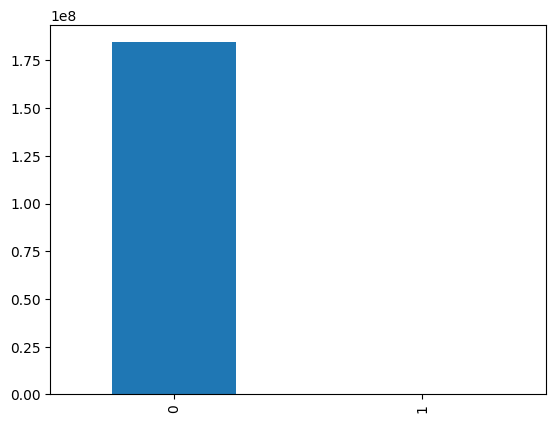

In [25]:
# See the imbalance in our dataset visually
pandas_train['IS_ATTRIBUTED'].value_counts().plot(kind='bar')

<Axes: xlabel='OS'>

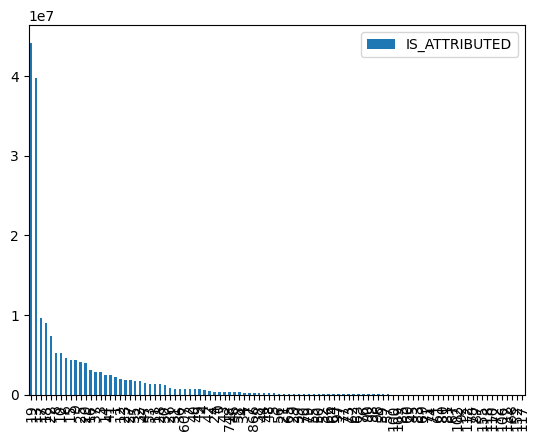

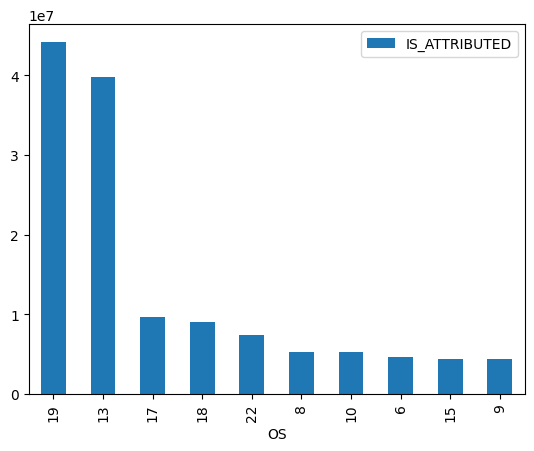

In [26]:
# Repeat an earlier groupby from our snowpark section, then add on a visualization
os_attributed_counts = pandas_train.groupby(['OS'])[["IS_ATTRIBUTED"]].count().sort_values(by="IS_ATTRIBUTED", ascending=False)
os_attributed_counts.head(100).plot(kind='bar', xlabel='')
os_attributed_counts.head(10).plot(kind='bar')

Can see that two groups of OS' account of a huge amount of our data.  Remember that we have 800 OS categories and that 220 of them only get attributed once.  We see four OS' that are on the order of 1e7 counts above.

<Axes: xlabel='IP'>

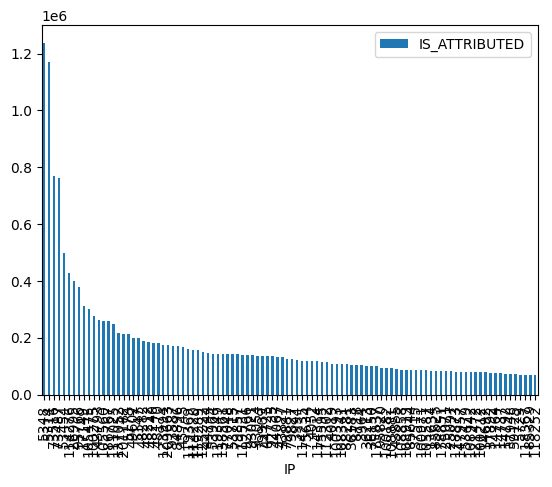

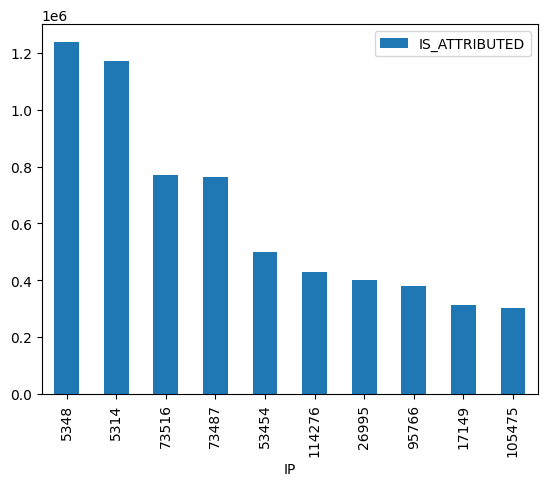

In [27]:
ip_attributed_counts = pandas_train.groupby(['IP'])[["IS_ATTRIBUTED"]].count().sort_values(by="IS_ATTRIBUTED", ascending=False)
ip_attributed_counts.head(100).plot(kind='bar')
ip_attributed_counts.head(10).plot(kind='bar')

Our IP groupings have a much more gradual falloff and also approach ~2e5 asymptotically rather than 0.  Still clearly influential as a category to determine if a click gets attributed

<Axes: xlabel='APP'>

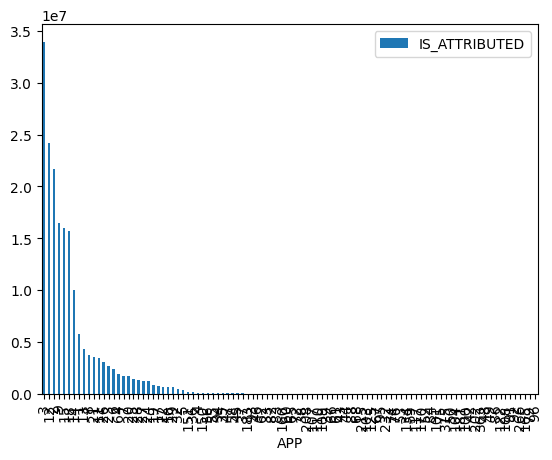

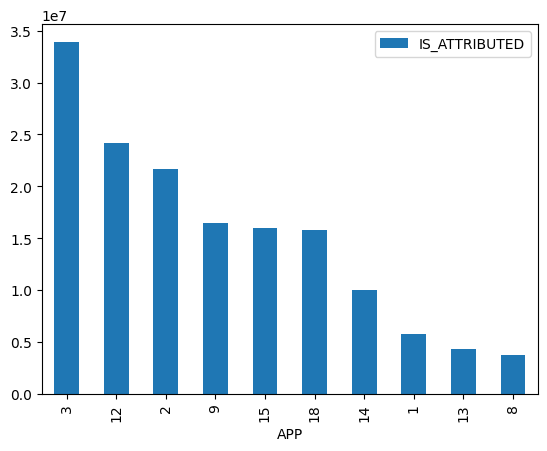

In [28]:
app_attributed_counts = pandas_train.groupby(['APP'])[["IS_ATTRIBUTED"]].count().sort_values(by="IS_ATTRIBUTED", ascending=False)
app_attributed_counts.head(100).plot(kind='bar')
app_attributed_counts.head(10).plot(kind='bar')

Falls off quickly to 0.  Will probably be useful as a predictor

<Axes: xlabel='DEVICE'>

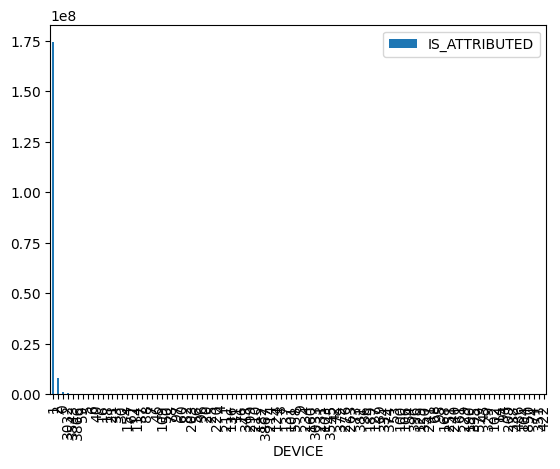

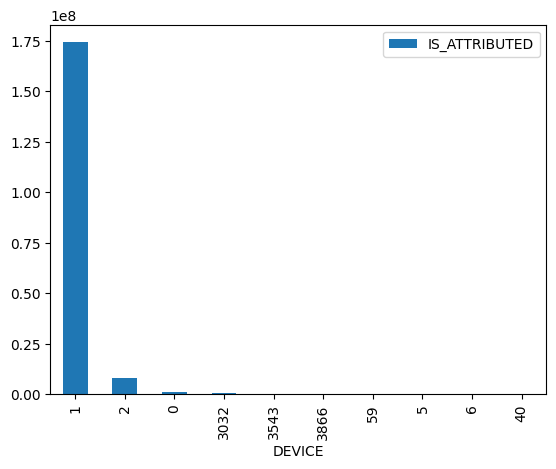

In [29]:
dev_attributed_counts = pandas_train.groupby(['DEVICE'])[["IS_ATTRIBUTED"]].count().sort_values(by="IS_ATTRIBUTED", ascending=False)
dev_attributed_counts.head(100).plot(kind='bar')
dev_attributed_counts.head(10).plot(kind='bar')

Really only one category here.  May not be useful.

In [30]:
pandas_train.head()

,IP,APP,DEVICE,OS,CHANNEL,CLICK_TIME,ATTRIBUTED_TIME,IS_ATTRIBUTED
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0


<Axes: xlabel='CHANNEL'>

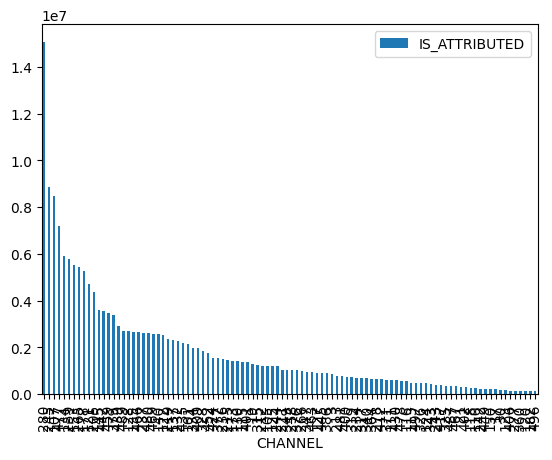

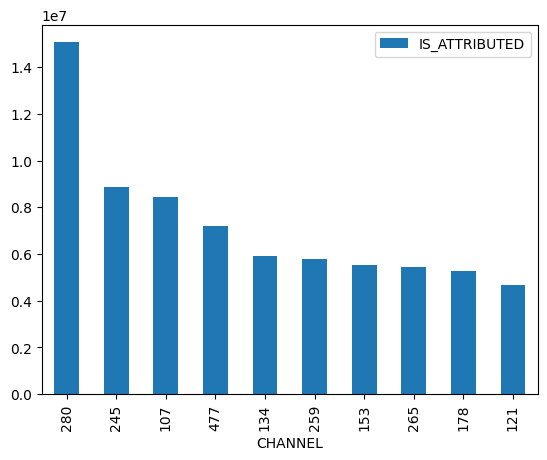

In [31]:
cha_attributed_counts = pandas_train.groupby(['CHANNEL'])[["IS_ATTRIBUTED"]].count().sort_values(by="IS_ATTRIBUTED", ascending=False)
cha_attributed_counts.head(100).plot(kind='bar')
cha_attributed_counts.head(10).plot(kind='bar')

More similar to IP.  Probably will be useful, but not as much as say OS or APP

### Temporal graphs
Examine click time and attributed time graphs

Text(0, 0.5, 'QTY Attributions')

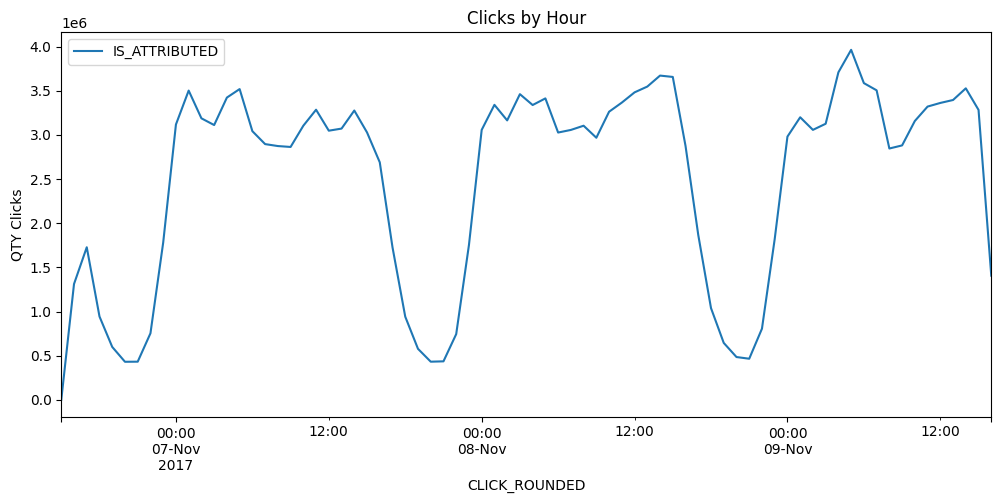

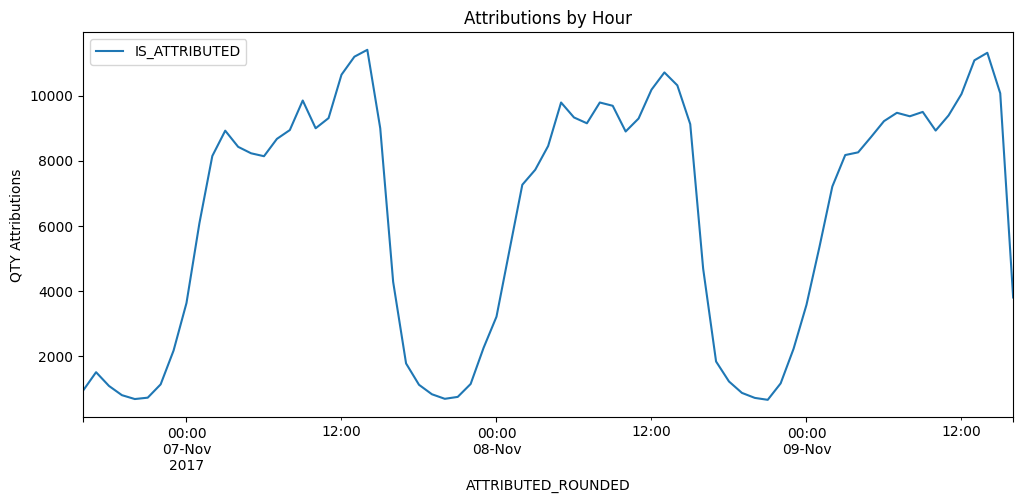

In [32]:
# For a larger dataset we'd check yearly/monthly/daily patterns, but since this only spans a few days we'll start with hourly

# Round click / attribution times to nearest hour
pandas_train['CLICK_ROUNDED'] = pandas_train['CLICK_TIME'].dt.round('H')
pandas_train['ATTRIBUTED_ROUNDED'] = pandas_train['ATTRIBUTED_TIME'].dt.round('H')

# Plot of clicks by hour, over time, where it ended with an attribution
pandas_train[['CLICK_ROUNDED', 'IS_ATTRIBUTED']].groupby(['CLICK_ROUNDED'], as_index=True).count().plot(figsize=(12,5)) 
plt.title("Clicks by Hour")
plt.ylabel("QTY Clicks")


# Plot of times that attributions occured by hour, over time
pandas_train[['ATTRIBUTED_ROUNDED', 'IS_ATTRIBUTED']].groupby(['ATTRIBUTED_ROUNDED'], as_index=True).count().plot(figsize=(12,5)) 
plt.title("Attributions by Hour")
plt.ylabel("QTY Attributions")

Clearly there are good and bad times.  Can see that the attributions being completed seem to have quite the correlation with the original click time.  The fact that the hour is such a clearly important feature means that we will want to use it as part of our model.  Can't add attributed hour as that would just be telling us whether there was an attribution or not which is the end goal of the model.

In [33]:
# Get the hour itself from our click time as that is what we will use in our model
pandas_train['CLICK_HOUR'] = pandas_train['CLICK_TIME'].dt.hour

<Axes: xlabel='CLICK_HOUR'>

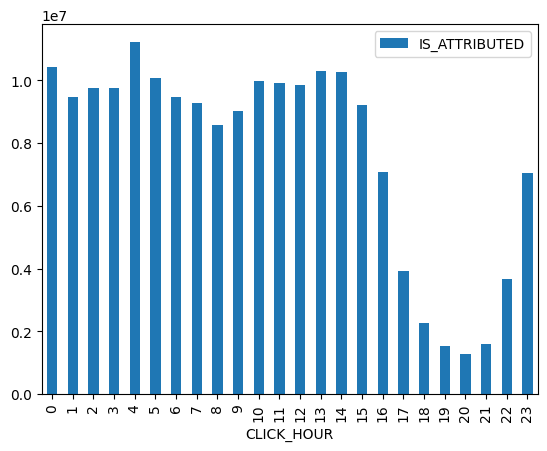

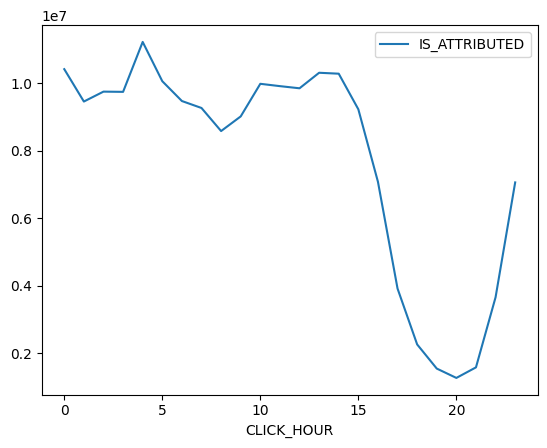

In [34]:
# Examine our new feature as a bar / line plot
pandas_train[['CLICK_HOUR', 'IS_ATTRIBUTED']].groupby(['CLICK_HOUR'], as_index=True).count().plot(kind='bar')
pandas_train[['CLICK_HOUR', 'IS_ATTRIBUTED']].groupby(['CLICK_HOUR'], as_index=True).count().plot()

Click minute will almost certainly add no predictive power based on the graph commented out below

In [35]:
# pandas_train['CLICK_MINUTE'] = pandas_train['CLICK_TIME'].dt.minute
# # Examine our new feature as a bar / line plot
# pandas_train[['CLICK_MINUTE', 'IS_ATTRIBUTED']].groupby(['CLICK_MINUTE'], as_index=True).count().plot(kind='bar')
# pandas_train[['CLICK_MINUTE', 'IS_ATTRIBUTED']].groupby(['CLICK_MINUTE'], as_index=True).count().plot()

Looking more in to the attributed time could be interesting, but since it can not go in to our model we will go without for now.

### Final Dataframe
We have a basic understanding of our variables and know what we expect to work as well as what we can keep going in to our model making.

In [36]:
# Basically just our original dataframe, plus a 'CLICK_HOUR' column and minus the 'CLICK_TIME' will be what we use
pandas_train.head()

,IP,APP,DEVICE,OS,CHANNEL,CLICK_TIME,ATTRIBUTED_TIME,IS_ATTRIBUTED,CLICK_ROUNDED,ATTRIBUTED_ROUNDED,CLICK_HOUR
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,2017-11-06 15:00:00,NaT,14
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0,2017-11-06 15:00:00,NaT,14
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0,2017-11-06 15:00:00,NaT,14
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0,2017-11-06 15:00:00,NaT,14
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0,2017-11-06 15:00:00,NaT,14


In [37]:
# We drop click_time as it will obviously be heavily correlated with click_time and we know hour has some predictive power already
pandas_train.drop(columns=['CLICK_ROUNDED', 'ATTRIBUTED_ROUNDED', 'CLICK_TIME'], inplace=True)

In [38]:
pandas_train['CLICK_HOUR'] = pandas_train['CLICK_HOUR'].astype('category')

In [39]:
pandas_train.dtypes

IP                       category
APP                      category
DEVICE                   category
OS                       category
CHANNEL                  category
ATTRIBUTED_TIME    datetime64[ns]
IS_ATTRIBUTED            category
CLICK_HOUR               category
dtype: object

In [ ]:
pandas_train.head()

In [ ]:
session.close()